This script is designed to set up an environment and run a stable diffusion model using the Deforum Stable Diffusion repository. It configures various settings and parameters for the model, handles environment setup, and dispatches different rendering tasks based on user input.

# 1. Environment Setup
The setup_environment function checks if the script is running in Google Colab. If it is, it installs necessary packages and clones the Deforum Stable Diffusion repository. It also sets up the system paths to include the repository directories. The function tracks the time taken for setup and skips the setup if not in Colab.

In [20]:
import subprocess
import time
import gc
import os
import sys

def setup_environment():
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        start_time = time.time()
        packages = [
            'xformers',  # Install xformers without version specification
            'einops==0.4.1', 'pytorch-lightning==1.7.7', 'torchdiffeq==0.2.3', 'torchsde==0.2.5',
            'ftfy', 'timm', 'transformers', 'open-clip-torch', 'omegaconf', 'torchmetrics==0.11.4',
            'safetensors', 'kornia', 'accelerate', 'jsonmerge', 'matplotlib', 'resize-right',
            'scikit-learn', 'numpngw', 'pydantic'
        ]
        for package in packages:
            print(f"..installing {package}")
            subprocess.check_call(['pip', 'install', '--upgrade', package])
        if not os.path.exists("deforum-stable-diffusion"):
            subprocess.check_call(['git', 'clone', '-b', '0.7.1', 'https://github.com/deforum-art/deforum-stable-diffusion.git'])
        else:
            print("..deforum-stable-diffusion already exists")
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend(['deforum-stable-diffusion/', 'deforum-stable-diffusion/src'])
        end_time = time.time()
        print(f"..environment set up in {end_time-start_time:.0f} seconds")
    else:
        sys.path.extend(['src'])
        print("..skipping setup")

setup_environment()
import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
from helpers.prompts import Prompts


..installing xformers
..installing einops==0.4.1
..installing pytorch-lightning==1.7.7
..installing torchdiffeq==0.2.3
..installing torchsde==0.2.5
..installing ftfy
..installing timm
..installing transformers
..installing open-clip-torch
..installing omegaconf
..installing torchmetrics==0.11.4
..installing safetensors
..installing kornia
..installing accelerate
..installing jsonmerge
..installing matplotlib
..installing resize-right
..installing scikit-learn
..installing numpngw
..installing pydantic
..deforum-stable-diffusion already exists
..environment set up in 130 seconds


# 2. Path Setup
The PathSetup function sets up paths for models, configs, and outputs, with an option to mount Google Drive for storing models and outputs. The root object (an instance of SimpleNamespace) holds these paths.

In [21]:
def path_setup():
    models_path = "models"
    configs_path = "configs"
    output_path = "outputs"
    mount_google_drive = True
    models_path_gdrive = "/content/drive/MyDrive/AI/models"
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion"
    return locals()

root = SimpleNamespace(**path_setup())
root.models_path, root.output_path = get_model_output_paths(root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


# 3. Model Setup
The ModelSetup function configures the model's location and version, including options for custom configurations and checkpoints. It updates the root object with these settings and loads the model.

In [22]:
def model_setup():
    map_location = "cuda"
    model_config = "v1-inference.yaml"
    model_checkpoint = "Protogen_V2.2.ckpt"
    custom_config_path = ""
    custom_checkpoint_path = ""
    return locals()

root.__dict__.update(model_setup())
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location=root.map_location)

config_path: /content/deforum-stable-diffusion/configs/v1-inference.yaml
ckpt_path: /content/drive/MyDrive/AI/models/Protogen_V2.2.ckpt
..checking sha256
..hash is correct
..loading model


# 4. Deforum Animation Arguments
The DeforumAnimArgs function defines various parameters for animation, including motion parameters, sampler scheduling, depth warping, video input, hybrid video settings, and interpolation. These settings allow for detailed control over how animations are generated.

In [23]:
def deforum_anim_args():
    animation_mode = 'None'
    max_frames = 1000
    border = 'replicate'

    angle = "0:(0)"
    zoom = "0:(1.04)"
    translation_x = "0:(10*sin(2*3.14*t/10))"
    translation_y = "0:(0)"
    translation_z = "0:(10)"
    rotation_3d_x = "0:(0)"
    rotation_3d_y = "0:(0)"
    rotation_3d_z = "0:(0)"
    flip_2d_perspective = False
    perspective_flip_theta = "0:(0)"
    perspective_flip_phi = "0:(t%15)"
    perspective_flip_gamma = "0:(0)"
    perspective_flip_fv = "0:(53)"
    noise_schedule = "0: (0.02)"
    strength_schedule = "0: (0.65)"
    contrast_schedule = "0: (1.0)"
    hybrid_comp_alpha_schedule = "0:(1)"
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)"
    hybrid_comp_mask_contrast_schedule = "0:(1)"
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule = "0:(100)"
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule = "0:(0)"

    enable_schedule_samplers = False
    sampler_schedule = "0:('euler'),10:('dpm2'),20:('dpm2_ancestral'),30:('heun'),40:('euler'),50:('euler_ancestral'),60:('dpm_fast'),70:('dpm_adaptive'),80:('dpmpp_2s_a'),90:('dpmpp_2m')"

    kernel_schedule = "0: (5)"
    sigma_schedule = "0: (1.0)"
    amount_schedule = "0: (0.2)"
    threshold_schedule = "0: (0.0)"

    color_coherence = 'Match Frame 0 LAB'
    color_coherence_video_every_N_frames = 1
    color_force_grayscale = False
    diffusion_cadence = '1'

    use_depth_warping = True
    midas_weight = 0.3
    near_plane = 200
    far_plane = 10000
    fov = 40
    padding_mode = 'border'
    sampling_mode = 'bicubic'
    save_depth_maps = False

    video_init_path = '/content/video_in.mp4'
    extract_nth_frame = 1
    overwrite_extracted_frames = True
    use_mask_video = False
    video_mask_path = '/content/video_in.mp4'

    hybrid_generate_inputframes = False
    hybrid_use_first_frame_as_init_image = True
    hybrid_motion = "None"
    hybrid_motion_use_prev_img = False
    hybrid_flow_method = "DIS Medium"
    hybrid_composite = False
    hybrid_comp_mask_type = "None"
    hybrid_comp_mask_inverse = False
    hybrid_comp_mask_equalize = "None"
    hybrid_comp_mask_auto_contrast = False
    hybrid_comp_save_extra_frames = False
    hybrid_use_video_as_mse_image = False

    interpolate_key_frames = False
    interpolate_x_frames = 20

    resume_from_timestring = False
    resume_timestring = "20220829210106"

    return locals()

# 5. Prompt Setup
Prompts for image generation are defined in dictionaries prompts and neg_prompts, specifying positive and negative prompts at different frames.

In [29]:
prompts = {
    0: "mona lisa",
    10: "Van gogh starry night",
}

neg_prompts = {
    0: "sports",
}


# 6. Argument Loading
The DeforumArgs function sets up parameters for image generation, including image dimensions, sampling settings, batch settings, initialization settings, exposure/contrast, color matching, CLIP/aesthetics settings, conditional gradient settings, and speed vs. VRAM settings.

INFO:pytorch_lightning.utilities.seed:Global seed set to 422364740


Saving to /content/drive/MyDrive/AI/StableDiffusion/2024-07/StableFun/20240705232818_*
Prompt 1 of 2
cond_prompt: mona lisa
uncond_prompt: sports
Batch 1 of 1
tenc: 50


100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


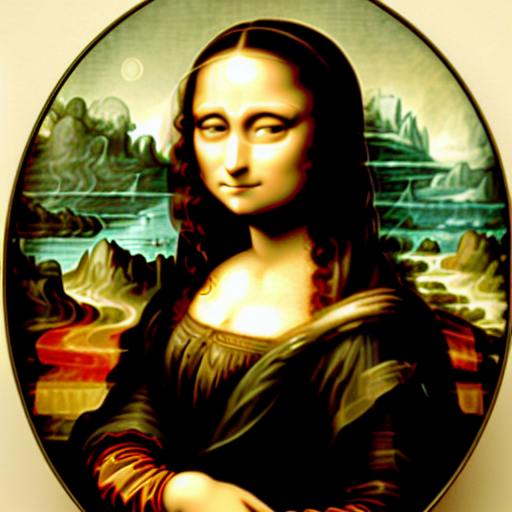

INFO:pytorch_lightning.utilities.seed:Global seed set to 422364741


Prompt 2 of 2
cond_prompt: Van gogh starry night
uncond_prompt: sports
Batch 1 of 1
tenc: 50


100%|██████████| 50/50 [00:07<00:00,  6.29it/s]


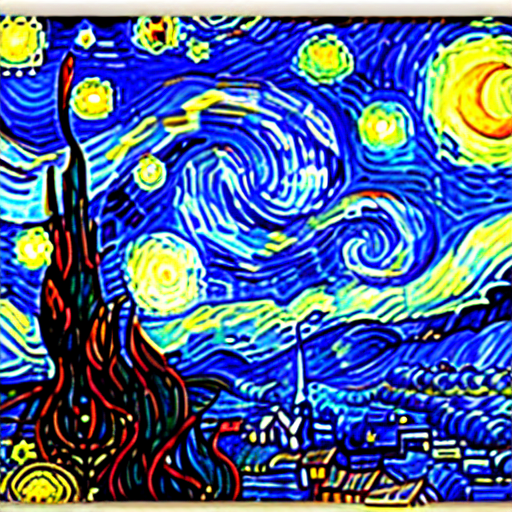

In [30]:
# Define function to load settings and initialize arguments
def load_settings_and_initialize():
    # Load the necessary settings
    def DeforumArgs():
        # Image Settings
        W = 512
        H = 512
        W, H = map(lambda x: x - x % 64, (W, H))
        bit_depth_output = 8

        # Sampling Settings
        seed = -1
        sampler = 'euler_ancestral'
        steps = 50
        scale = 7
        ddim_eta = 0.0
        dynamic_threshold = None
        static_threshold = None

        # Save & Display Settings
        save_samples = True
        save_settings = True
        display_samples = True
        save_sample_per_step = False
        show_sample_per_step = False

        # Batch Settings
        n_batch = 1
        n_samples = 1
        batch_name = "StableFun"
        filename_format = "{timestring}_{index}_{prompt}.png"
        seed_behavior = "iter"
        seed_iter_N = 1
        make_grid = False
        grid_rows = 2
        outdir = get_output_folder(root.output_path, batch_name)

        # Init Settings
        use_init = False
        strength = 0.65
        strength_0_no_init = True
        init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg"
        add_init_noise = False
        init_noise = 0.01
        use_mask = False
        use_alpha_as_mask = False
        mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg"
        invert_mask = False
        mask_brightness_adjust = 1.0
        mask_contrast_adjust = 1.0
        overlay_mask = True
        mask_overlay_blur = 5

        # Exposure/Contrast Conditional Settings
        mean_scale = 0
        var_scale = 0
        exposure_scale = 0
        exposure_target = 0.5

        # Color Match Conditional Settings
        colormatch_scale = 0
        colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png"
        colormatch_n_colors = 4
        ignore_sat_weight = 0

        # CLIP\Aesthetics Conditional Settings
        clip_name = 'ViT-L/14'
        clip_scale = 0
        aesthetics_scale = 0
        cutn = 1
        cut_pow = 0.0001

        # Other Conditional Settings
        init_mse_scale = 0
        init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg"
        blue_scale = 0

        # Conditional Gradient Settings
        gradient_wrt = 'x0_pred'
        gradient_add_to = 'both'
        decode_method = 'linear'
        grad_threshold_type = 'dynamic'
        clamp_grad_threshold = 0.2
        clamp_start = 0.2
        clamp_stop = 0.01
        grad_inject_timing = list(range(1, 10))

        # Speed vs VRAM Settings
        cond_uncond_sync = True
        precision = 'autocast'
        C = 4
        f = 8

        cond_prompt = ""
        cond_prompts = ""
        uncond_prompt = ""
        uncond_prompts = ""
        timestring = ""
        init_latent = None
        init_sample = None
        init_sample_raw = None
        mask_sample = None
        init_c = None
        seed_internal = 0

        return locals()

    args_dict = DeforumArgs()
    anim_args_dict = deforum_anim_args()

    if override_settings_with_file:
        load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

    args = SimpleNamespace(**args_dict)
    anim_args = SimpleNamespace(**anim_args_dict)

    args.timestring = time.strftime('%Y%m%d%H%M%S')
    args.strength = max(0.0, min(1.0, args.strength))

    return args, anim_args

# Load settings and initialize arguments
args, anim_args = load_settings_and_initialize()

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

# Set random seed if not provided
if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)

# Handle init image settings
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

# Adjust animation settings based on mode
if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# Clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# Get prompts
cond, uncond = Prompts(prompt=prompts, neg_prompt=neg_prompts).as_dict()

# Dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond, uncond)
else:
    render_image_batch(root, args, cond, uncond)


# Summary
The script sets up a stable diffusion environment, configures the model and rendering settings, and dispatches tasks to generate images or animations based on user-specified parameters. It is highly configurable, allowing for various effects and optimizations in generating the desired outputs.